# Proyek Klasifikasi Gambar: Skin Cancer Dataset
- **Nama:** Leonard Bodhi Kumaro
- **Email:** bkleonard174@gmail.com
- **ID Dicoding:** leonardkumaro


## Introduction


Kanker kulit, khususnya melanoma, adalah salah satu jenis kanker yang paling umum dan berbahaya, dengan deteksi dini yang sangat penting untuk meningkatkan hasil pengobatan pasien. Sistem deteksi otomatis yang memanfaatkan pembelajaran mendalam dapat secara signifikan meningkatkan akurasi dan efisiensi diagnostik. Dalam proyek ini, saya mengembangkan model berbasis Convolutional Neural Network (CNN) menggunakan arsitektur canggih seperti equential CNN dengan 3 blok konvolusi dan 2 dense layer untuk mengklasifikasikan lesi kulit dari kumpulan data ISIC. Model ini menjawab tantangan utama seperti variasi warna kulit, kondisi pencahayaan, dan morfologi lesi. Dengan menerapkan teknik augmentasi data dan pembelajaran transfer, saya bertujuan untuk menciptakan pengklasifikasi yang kuat yang mampu membantu dokter kulit dalam deteksi dini melanoma.

## Import Semua Packages/Library yang Digunakan

In [19]:
# Mengimpor library yang diperlukan
import os
import numpy as np
import pandas as pd

from PIL import Image
from glob import glob
from sklearn.preprocessing import LabelEncoder, StandardScaler
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import pydot
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization,Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from IPython.display import display

## Data Preparation

### Data Loading

In [2]:
# Mengimpor library kagglehub untuk mengunduh dataset
import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')

Data source import complete.


There are 5 csv files in the current version of the dataset:


In [3]:
# Mengatur direktori kerja
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0032809.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0031479.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0030506.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0031986.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0033624.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029352.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0032582.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0033152.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0033974.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0031417.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_part_2/ISIC_0029889.jpg
/kaggle/input/skin-cancer-mnist-ham10000/ham10000_images_p

### Data Preprocessing

In [4]:
# Mengatur direktori data
data_directory = os.path.join("/kaggle/input/", "skin-cancer-mnist-ham10000/")
os.listdir(data_directory)

data = pd.read_csv(os.path.join(data_directory, 'HAM10000_metadata.csv'))

In [5]:
# Menampilkan 5 baris pertama dari data
data.head()
# Menampilkan informasi tentang data
data.info()
# Menampilkan statistik deskriptif dari data
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


,age
count,9958.000000
mean,51.863828
std,16.968614
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [6]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(data_directory, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())
# Menambahkan kolom cell_type dan image_path
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)


# Menambahkan piksel gambar
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel
3077,HAM_0006178,ISIC_0031100,nv,follow_up,55.0,male,lower extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[210, 134, 149], [211, 133, 149], [210, 129,..."
6000,HAM_0005441,ISIC_0031804,nv,follow_up,55.0,male,back,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[219, 125, 159], [220, 124, 160], [219, 122,..."
3215,HAM_0000041,ISIC_0032211,nv,follow_up,45.0,female,scalp,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[167, 87, 102], [171, 90, 107], [172, 92, 11..."
8749,HAM_0000896,ISIC_0025051,nv,histo,45.0,female,lower extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[215, 191, 189], [215, 191, 189], [216, 194,..."
7615,HAM_0000855,ISIC_0033694,nv,histo,45.0,male,upper extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[200, 166, 189], [199, 162, 185], [199, 158,..."


In [7]:
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=data['sex'].value_counts().index,
            y=data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=data['localization'].value_counts().index,
            y=data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data', height=800)

fig.show()

<ipython-input-8-99d016c0a5e4>:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

<ipython-input-8-99d016c0a5e4>:6: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-8-99d016c0a5e4>:7: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



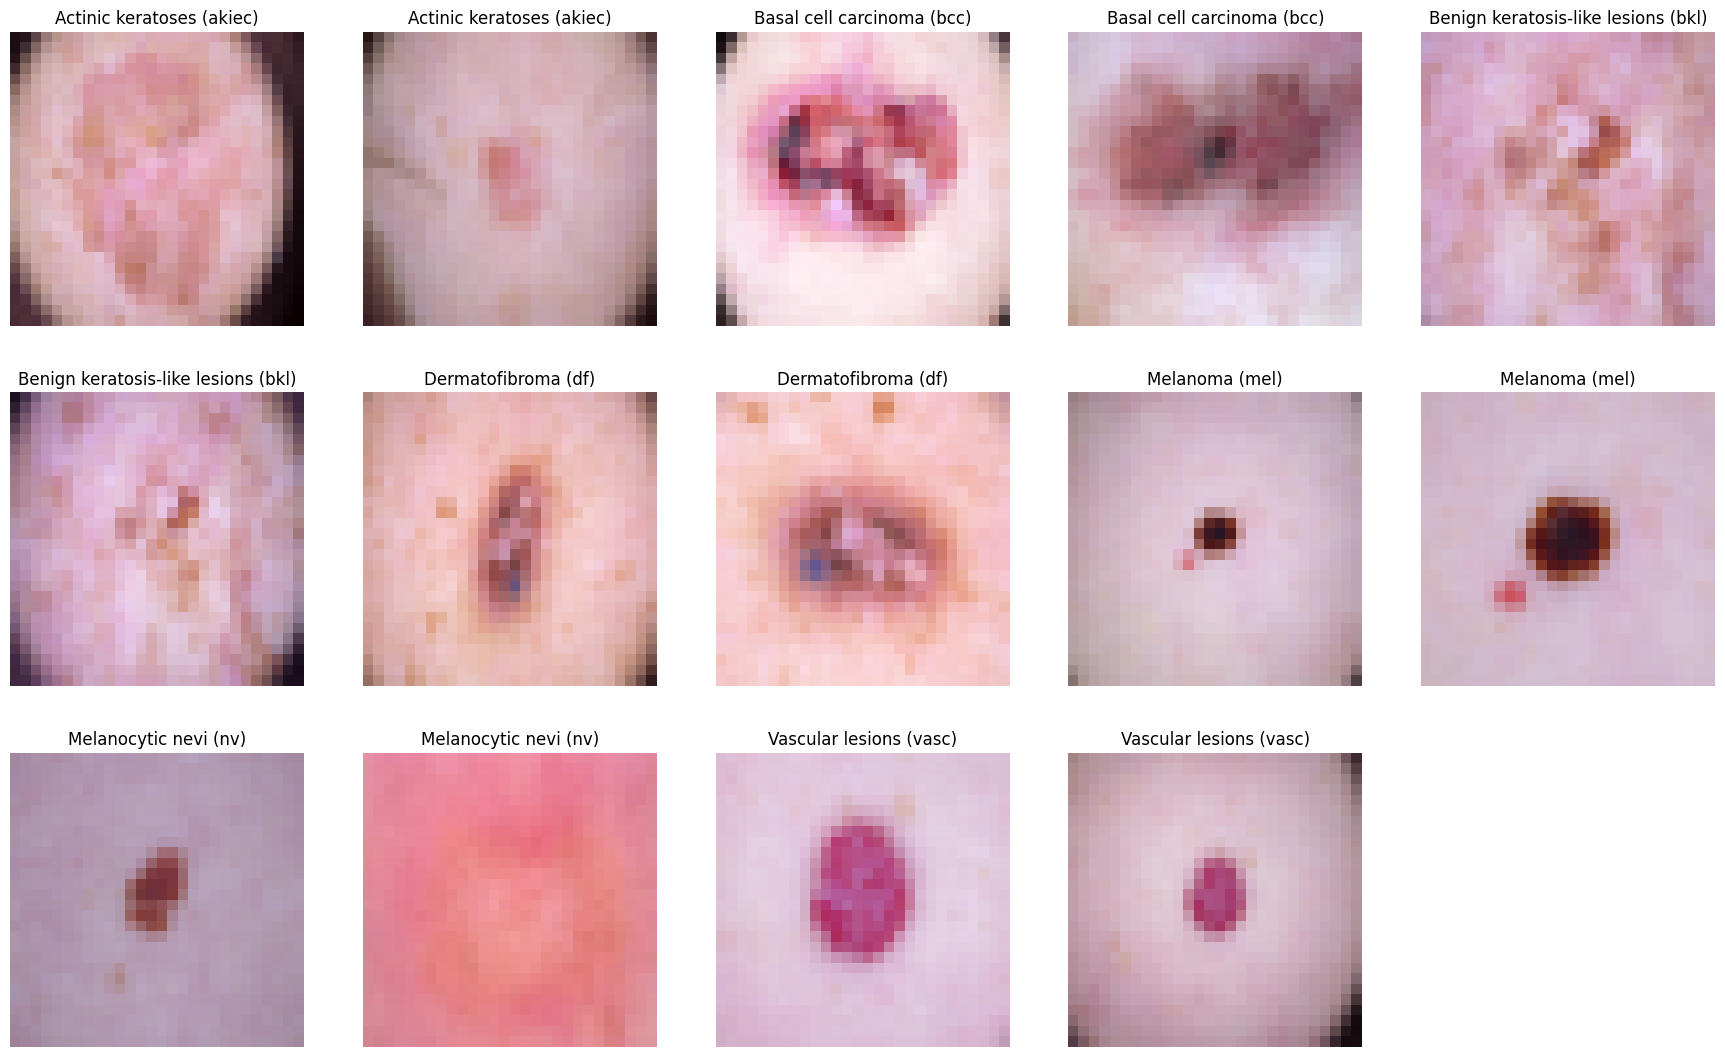

In [8]:
# Menampilkan 2 gambar untuk setiap label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show()


In [9]:
# Memeriksa nilai nol
data.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0
cell_type,0
path,0
image_pixel,0


In [10]:
# Menangani nilai nol
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Mengonversi tipe data usia menjadi int32
data['age'] = data['age'].astype('int32')
# Label pengkodean gambar secara kategoris
data['label'] = data['dx'].map(reverse_label_mapping.get)
data.sample(5)

<ipython-input-10-fe81fe14e6c0>:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,image_pixel,label
1174,HAM_0000349,ISIC_0033005,df,consensus,45,female,lower extremity,Dermatofibroma (df),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[69, 44, 44], [122, 94, 88], [161, 133, 124]...",6
10014,HAM_0003521,ISIC_0032258,mel,histo,70,female,back,Melanoma (mel),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[176, 142, 121], [181, 149, 133], [181, 149,...",1
8943,HAM_0000889,ISIC_0026401,nv,histo,30,female,lower extremity,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[205, 182, 195], [206, 183, 196], [208, 185,...",0
1742,HAM_0003073,ISIC_0034183,mel,histo,50,male,abdomen,Melanoma (mel),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[173, 161, 170], [174, 162, 171], [177, 164,...",1
3083,HAM_0005619,ISIC_0025415,nv,follow_up,45,male,abdomen,Melanocytic nevi (nv),/kaggle/input/skin-cancer-mnist-ham10000/ham10...,"[[[232, 157, 176], [219, 142, 161], [239, 158,...",0


### Data Augmentation

In [11]:
data = data.sort_values('label')
data = data.reset_index(drop=True)

In [12]:
index1 = data[data['label'] == 1].index.values
index2 = data[data['label'] == 2].index.values
index3 = data[data['label'] == 3].index.values
index4 = data[data['label'] == 4].index.values
index5 = data[data['label'] == 5].index.values
index6 = data[data['label'] == 6].index.values

df_index1 = data.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = data.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = data.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = data.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = data.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = data.iloc[int(min(index6)):int(max(index6)+1)]

df_index1 = pd.concat([df_index1] * 5, ignore_index=True)
df_index2 = pd.concat([df_index2] * 5, ignore_index=True)
df_index3 = pd.concat([df_index3] * 12, ignore_index=True)
df_index4 = pd.concat([df_index4] * 18, ignore_index=True)
df_index5 = pd.concat([df_index5] * 46, ignore_index=True)
df_index6 = pd.concat([df_index6] * 53, ignore_index=True)

frames = [data, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames)

print(data.shape)
print(final_data.shape)
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localisation', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index,
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index,
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=final_data['dx'].value_counts()),
            row=2, col=2)

for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)
fig.update_layout(title='Distribution of Data after augmentation', height=800)

fig.show()

(10015, 11)
(45756, 11)


In [13]:
# DATA ASLI
# Mengonversi kolom piksel gambar ke dalam format yang diperlukan
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

(10015, 28, 28, 3)
(10015, 1)


In [14]:
# DATA AUGMENTASI
# Mengonversi kolom piksel gambar ke dalam format yang diperlukan
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

(45756, 28, 28, 3)
(45756, 1)


#### Split Dataset

In [15]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Prepare data for training and testing the model
    train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 10,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  fill_mode = 'nearest')
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

## Modelling

In [23]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3),
    activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                 optimizer = optimizer,
                  metrics = ['accuracy'])
    print(model.summary())
    tf.keras.utils.plot_model(model, to_file="model.png")
    return model;

def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'],
            name='train_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'],
            name='val_acc'),
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'],
            name='train_loss'),
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'],
            name='val_loss'),
        row=1, col=2)
    fig.show()

def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)

    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show()

## Evaluasi dan Visualisasi

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5822 - loss: 1.9243 - val_accuracy: 0.6475 - val_loss: 0.9635 - learning_rate: 0.0010
Epoch 2/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6952 - loss: 0.8850 - val_accuracy: 0.6800 - val_loss: 0.9002 - learning_rate: 0.0010
Epoch 3/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7069 - loss: 0.8468 - val_accuracy: 0.6999 - val_loss: 0.8423 - learning_rate: 0.0010
Epoch 4/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7152 - loss: 0.7994 - val_accuracy: 0.7049 - val_loss: 0.8154 - learning_rate: 0.0010
Epoch 5/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7092 - loss: 0.8050 - val_accuracy: 0.6045 - val_loss: 0.9362 - learning_rate: 0.0010
Epoch 6/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7044 - loss: 0.7943 - val_accuracy: 0.7018 - val_loss: 0.8472 - learning_rate: 0.0010
Epoch 7/40
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7318 - loss: 0.7

Test Accuracy: 75.037%
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
              precision    recall  f1-score   support

          nv       0.84      0.93      0.88      1374
         mel       0.48      0.34      0.40       205
         bkl       0.55      0.28      0.37       227
         bcc       0.40      0.74      0.52        94
       akiec       0.31      0.07      0.12        55
        vasc       0.78      0.50      0.61        28
          df       0.00      0.00      0.00        20

    accuracy                           0.75      2003
   macro avg       0.48      0.41      0.41      2003
weighted avg       0.72      0.75      0.72      2003



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



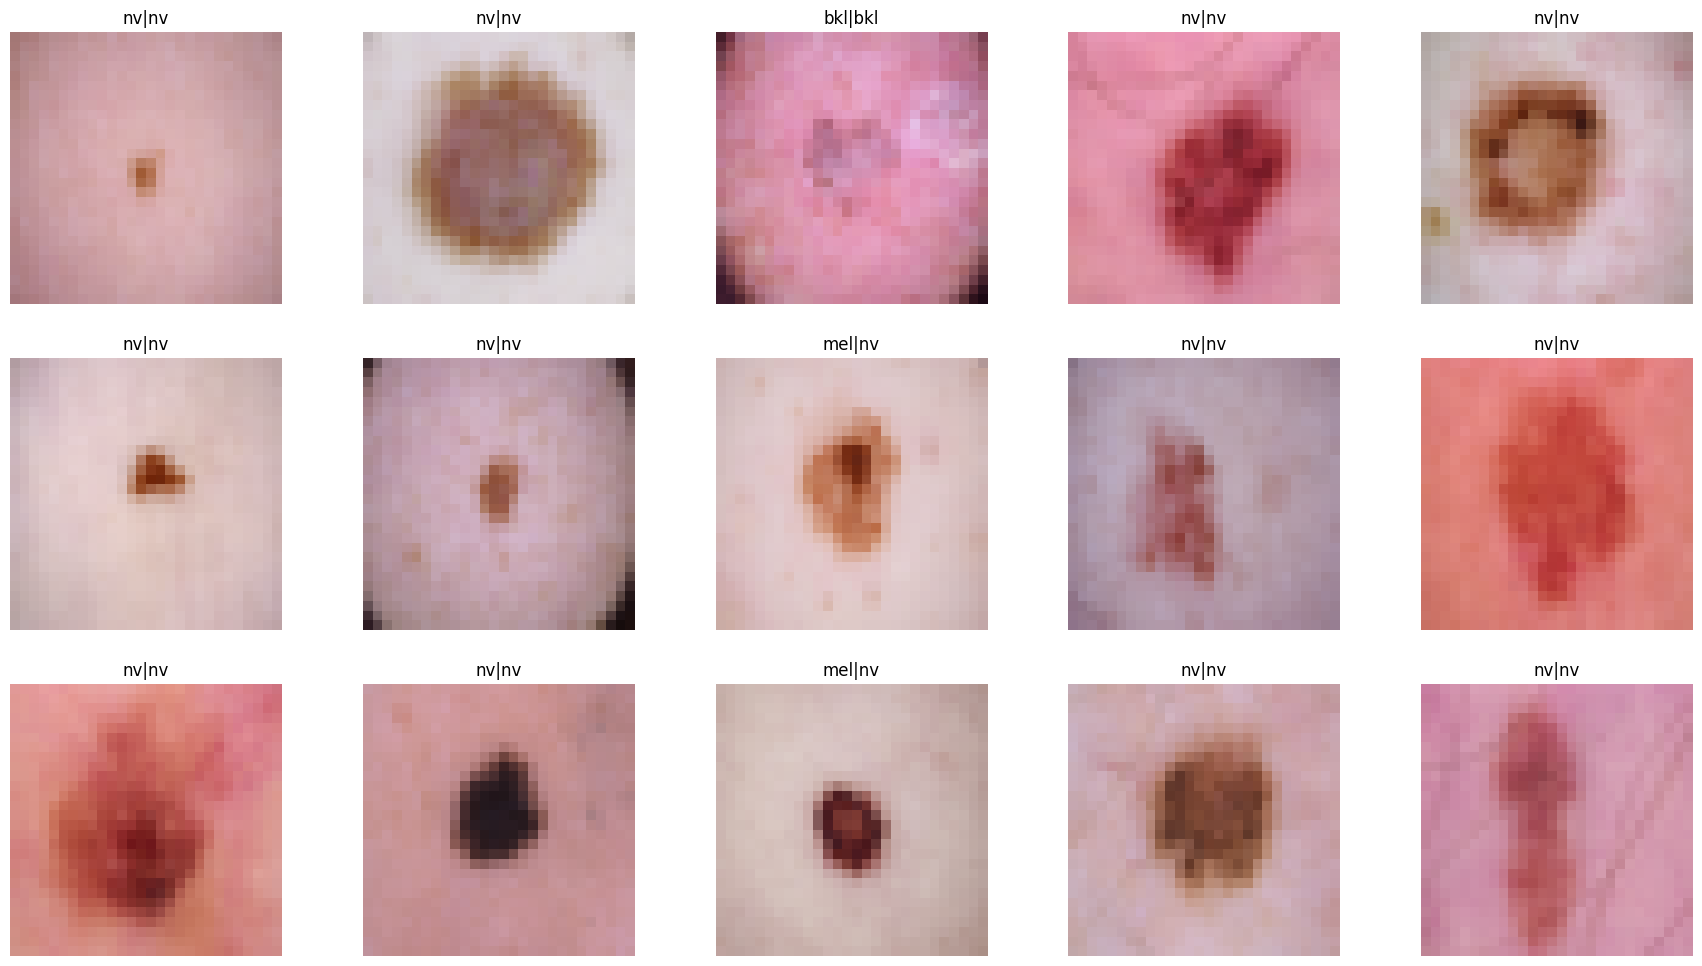

In [24]:
# For Original Dataset with new split
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

# Create model
model1 = create_model()

# Train model with validation data
history = train_model(model1, X_train_orig, Y_train_orig, 40)

# Plot training curves
plot_model_training_curve(history)

# Evaluate on test set
test_model(model1, X_test_orig, Y_test_orig)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 28, 28, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,583 (517.90 KB)

 Trainable params: 132,583 (517.90 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/40
458/458 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3353 - loss: 3.3562 - val_accuracy: 0.6119 - val_loss: 1.0318 - learning_rate: 0.0010
Epoch 2/40
458/458 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6323 - loss: 0.9501 - val_accuracy: 0.6947 - val_loss: 0.7768 - learning_rate: 0.0010
Epoch 3/40
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7418 - loss: 0.6803 - val_accuracy: 0.7957 - val_loss: 0.5678 - learning_rate: 0.0010
Epoch 4/40
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8104 - loss: 0.5192 - val_accuracy: 0.8506 - val_loss: 0.4101 - learning_rate: 0.0010
Epoch 5/40
458/458 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8714 - loss: 0.3571 - val_accuracy: 0.8267 - val_loss: 0.4510 - learning_rate: 0.0010
Epoch 6/40
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8878 - loss: 0.3038 - val_accuracy: 0.8757 - val_loss: 0.3515 - learning_rate: 0.0010
Epoch 7/40
458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9196 - loss: 0.2

Test Accuracy: 98.175%
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

          nv       0.99      0.89      0.94      1385
         mel       0.94      0.99      0.96      1328
         bkl       0.97      1.00      0.98      1294
         bcc       0.99      1.00      0.99      1325
       akiec       1.00      1.00      1.00      1270
        vasc       1.00      1.00      1.00      1293
          df       1.00      1.00      1.00      1257

    accuracy                           0.98      9152
   macro avg       0.98      0.98      0.98      9152
weighted avg       0.98      0.98      0.98      9152



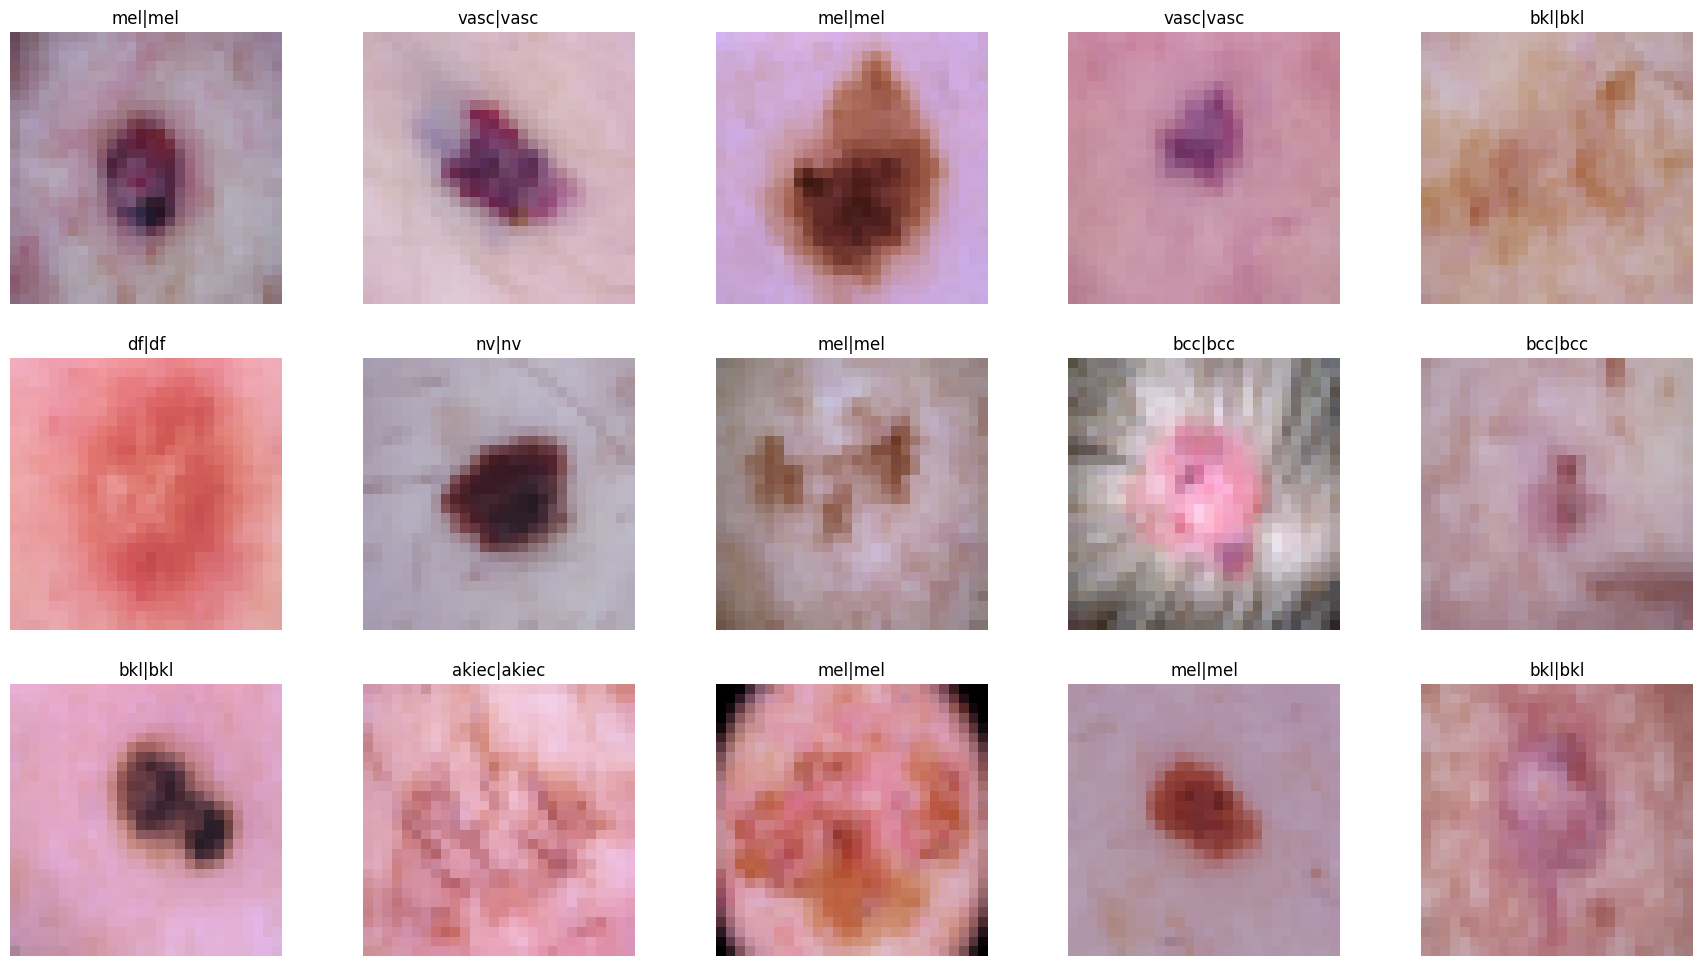

In [25]:
# For Augmented Dataset
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

# Create and train model
model2 = create_model()
# Pass the raw data arrays and generators to train_model
history_aug = train_model(model2, X_train_aug, Y_train_aug, 40)

# Plot training curves
plot_model_training_curve(history_aug)

# Evaluate on test set
test_model(model2, X_test_aug, Y_test_aug)

## Konversi Model

In [27]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [28]:
import tensorflowjs as tfjs

# Konversi ke format TensorFlow.js
tfjs.converters.save_keras_model(model2, 'tfjs_model')

# Untuk load di JavaScript:
# const model = await tf.loadLayersModel('path/to/model.json');

failed to lookup keras version from the file,
    this is likely a weight only file


In [29]:
# Convert to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Quantization (untuk mengurangi ukuran model)
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

with open('model_quantized.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

Saved artifact at '/tmp/tmpex81umvk'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 3), dtype=tf.float32, name='keras_tensor_239')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132371283432592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371350624528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371350623184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371350627792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371350625104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371350629712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371319192656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371319191888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371319190928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371319180752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132371319189

In [30]:
import os

# Create the directory if it doesn't exist
os.makedirs('saved_model', exist_ok=True)

# Export ke SavedModel
model2.save('saved_model/my_model.keras')  # Added .keras extension
# Untuk memuat kembali:
loaded_model = tf.keras.models.load_model('saved_model/my_model.keras') # Updated loading method to use the same extension

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 



## Inference (Optional)

In [31]:
import numpy as np
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input/output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prepare input - Changed to single image
input_shape = input_details[0]['shape']
sample_input = np.random.rand(1, 28, 28, 3).astype(np.float32)  # Now represents a single image

# Inference
interpreter.set_tensor(input_details[0]['index'], sample_input)
interpreter.invoke()

# Get output
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data[0])
confidence = np.max(output_data[0])

print(f"Predicted class: {predicted_class} with confidence {confidence:.2f}")

Predicted class: 2 with confidence 0.41
